# CSC413 Lab 1: Linear Models

In this lab, we will review **linear models** for classification, which was discussed in depth in CSC311.
We will use this as an opportunity to review key ideas, including the splitting of the dataset into
train/validation/test sets, optimization methods using Stochastic Gradient Descent, and so on.
This lab reviews Python libraries that you have used in CSC311, including `numpy`, `matplotlib` and others.

The main aim of this lab is to revisit the PyTorch library. PyTorch provides
automatic differentiation capabilities and other neural network tools.
This means that **we do not need to compute gradients ourselves**! Instead,
we rely on PyTorch to build the computation graph and compute gradients.
PyTorch can do this because it knows how to compute gradients for simple
operations like addition, multiplication, ReLU activation, and common
functions like exponentials, logarithms, and so on. The neural networks
we build require computation that are combinations of these simple operations.

For now, we will we solve a multi-class classification problem with PyTorch.

By the end of this lab, you will be able to:

1. Implement and train a multi-class logistic regression model using PyTorch.
2. Compute the accuracy metric for a machine learning model.
3. Compute numerically, via numpy, the gradient of a linear model.
4. Check that PyTorch correctly computes gradients for a linear model via automatic differentiation.
5. Identify and explain the elements of the training loop in a PyTorch implementation.
6. Identify optimization parameters and hyperparameters, and explain how hyperparameter choices impact training, underfitting and overfitting (i.e. bias/variance decomposition).

Please work in groups of 1-2 during the lab, but submit your own solution individually.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab01.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your explanation of the purpose of the training and validation sets. (1 point)
- Part 2. Your implementation of `accuracy_basic`. (2 point)
- Part 2. Your implementation of `accuracy_vectorized`. (1 point)
- Part 2. Your implementation of `accuracy`. (1 point)
- Part 3. Your computation of `model_bias_grad`. (2 points)
- Part 4. Your completion of `train_model`. (1 point)
- Part 5. Your list of hyperparameters. (1 point)
- Part 5. Your explanation of what happens if the learning rate is too large. (1 point)


## Google Colab Setup

We will use Google Colab to open the provided IPython Notebook (.ipynb) file.
This tool allows us to write and execute Python code through our browser, without any environmental setup.

Here are the steps to open .ipynb files on Google Colab.

1. Download `lab01.ipynb`, available from the Quercus course website.
2. Click on the following link to open Google Colab: https://colab.research.google.com/
3. Click "Upload", then choose the file which has been downloaded in step 1.

And that's it! Now we can start writing the codes, creating the new code or text cell, etc.

Here are some basic functionalities and features that you might find useful.

1. Running a cell \
    Click the run button on the left side of the code cell (looks like a “play” button with a triangle in a circle) \
    or \
    press SHIFT + ENTER.

2. Installing libraries using Bash Commands \
    Although most of the commonly used libraries (e.g. NumPy, Pandas, Matplotlib) are pre-installed,
    we may occasionally ask you to install new libraries or run other bash commands.
    Bash commands can be run by prefixing instructions in a code cell with '!' in Google Colab (One exception: 'cd' command can be run by prefixing with '%'), e.g. `!pip install [package name]`

3. Mounting Google Drive \
    You may optionally mount Google Drive.
    Click the files button on the left pane, then click on 'mount drive' button (looks like a file icon with a google drive logo). \
    or \
    Run the following code snippet:
    ```
    from google.colab import drive
    drive.mount('/content/drive')
    ```
    By mounting the drive, we can use any files or folders in our drive by using the path as follows:
    ```
    /content/drive/MyDrive/[folder name]
    ```
    For example, we can read the csv file uploaded in the drive using Pandas library as follows:
    ```
    pd.read_csv('/content/drive/MyDrive/myfolder/myfile.csv')
    ```

Now, we are ready to import the necessary packages and begin our lab.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Part 1. Data

We will use the MNIST data set, which consists of hand-written digits. This dataset is available within
the `torchvision.datasets` library. The dataset creators divided the MNIST imgages into a training and
test set, so that different researchers report test accuracy on a consistent set of images.
(Recall that the test set is to be set aside and **not** used during training or to make any model decisions,
and that it is used to estimate *how well your models generalize* to new data that it has never seen before.)

In [2]:
from torchvision.datasets import MNIST

mnist_train = MNIST(root=".",      # where on the disk to store the data
                    download=True, # download the data if it does not already exist
                    train=True)    # use the training set (rather than the test set)

100%|██████████| 9912422/9912422 [00:00<00:00, 75004304.88it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8219276.28it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49635346.70it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6316488.32it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



**Task:** If different practitioners are exploring machine learning models for the same task and data set,
why is it important that practitioners report their test performance (e.g., accuracy)
on the same test set?

In [ ]:
# TODO: So that thre is a "control" set on which everyone is testing, making the comparisons for test performance fair.

It is always a good idea to visually inspect our data before working with it.
First, let's take a look at the first element of the training set:

In [3]:
print(mnist_train[0]) # a tuple consisting of the image, and the label (5)

(<PIL.Image.Image image mode=L size=28x28 at 0x7D19B8B54DC0>, 5)


The image can be displayed on Google Colab using matplotlib:

In [ ]:
plt.imshow(mnist_train[0][0], cmap='gray') # display the image

It is important to note that images are represented using numbers on your machine.
Converting this image into a numpy array shows a representation of the image using
28x28 numbers, each representing a pixel value.

In [ ]:
print(np.array(mnist_train[0][0]))

**Task:** What does the numerical value 0 (smallest possible value) mean in the image?
What about the largest possible value, 255?

In [ ]:
# TODO: These values are representing the pixel intensity at those points. The number 0 represents black, and the number 255 represents White.

For our purposes, we will only use the first 5000 elements of the training set.
This is to make training faster.

PyTorch also makes it easy to apply pre-processing transformations to the data,
for example to normalize the data prior to using for training.
We will use the standard preprocessing functions to *transform the images into tensors* for PyTorch to be able to use.
This transformation also changes the values to be floating-point numbers between 0 and 1.
Performing this transformation to PyTorch tensors now makes it easier to use PyTorch functionalities to
help us create minibatches with this data.

In [ ]:
import torchvision.transforms as transforms

mnist_data = MNIST(root=".",      # where on the disk to store the data
                   download=True, # download the data if it does not already exist
                   train=True,    # use the canonical training set (rather than the test set)
                   transform=transforms.ToTensor()) # transforms the images into PyTorch tensors
mnist_data = list(mnist_data)[:5000]

print(mnist_data[0]) # a tuple consisting of a PyTorch tensor of shape (1, 28, 28) and an integer target label

We will split the data set into 3000 for training, 1000 for validation, and 1000 for test:

In [7]:
train_data = mnist_data[:3000]
val_data   = mnist_data[3000:4000]
test_data  = mnist_data[4000:]

**Graded Task**: We described, above, that the purpose of the **test set** is to estimate how well
our models would generalize to new data that it has never seen before.
What are the purposes of the training and validation sets?

In [ ]:
# TODO: The training and validation sets will act as the data that will be used to train the model. First the training data will be used
# to train the model parametres. Parametres here refer to the variables that are internal to the model. The validation set is then used
# to ensure that the model isn't overfit to the training data.

## Part 2. A Linear Model in PyTorch

You may recall from CSC311 that in machine learning, we often describe a model by first describing
how to make predictions with a model (e.g., multi-class classification), and **then** describe
how to find appropriate weights (e.g., an optimization method like gradient descent).
We will follow that process here.

Recall that, mathematically, the multi-class classification model can be written as follows:

$${\bf y} = \textrm{softmax}({\bf W} {\bf x} + {\bf b})$$

Where the ${\bf x}$ vector represents the input (i.e., the vector representation of the MNIST image),
and the ${\bf y}$ vector contains the predicted probably of the image being in each class (i.e.,
predicted probability of the image being of each digit 0-9).

**Task**: In the MNIST image classification task, what are the shapes of the quantities
${\bf x}$, ${\bf W}$, ${\bf b}$ and ${\bf y}$?

In [ ]:
# TODO: y = [10, 1]. b = [10, 1], x = [784, 1], W = [10, 784].

The matrix ${\bf W}$ and ${\bf b}$ are the parameters of the model. The matrix  ${\bf W}$ is
sometimes called the *weight matrix* and the vector ${\bf b}$ the *bias vector*, but these parameters
taken together are often referred to collectively as the **weights**.
"Good" values of the parameters ${\bf W}$ and ${\bf b}$ are those that would produce values of
the vector ${\bf y}$ that more accurately match the actual target label. We will need to discuss
what "good" means and how to measure "good"ness and optimize it. For now, let's begin by applying
and analyzing a "bad" model: a model where the parameters ${\bf W}$ and ${\bf b}$ are chosen
randomly.


Notice that there are two parts to the computation $\textrm{softmax}({\bf W} {\bf x} + {\bf b})$:
there is a *linear transformation* on ${\bf X}$, and then there is a softmax operation.
PyTorch models these two components separately.

The **linear transformation** is modeled as a Python class in PyTorch.
Since the parameters ${\bf W}$ and ${\bf b}$ are parameters of the linear transformation
portion of the computation, the weights and biases are class attributes.
The output of the linear transformation step is typically denoted using the symbol ${\bf z}$,
and is called the **logit** (or unnormalized logits).

In [8]:
import torch.nn as nn

model = nn.Linear(in_features=784,
                  out_features=10)

print(model.weight.size()) # the weight parameter, initialized to random values
print(model.bias.size())   # the bias parameter, initialized to random values

torch.Size([10, 784])
torch.Size([10])


This `model` object can be called like a function to perform the computation ${\bf W}{\bf x} + {\bf b}$:

In [9]:
# reshape the input image into the shape [1, 784]
# PyTorch always expects inputs of shape [batch_size, num_features]
x = train_data[0][0].reshape(1, 784)

# Computes z = Wx + b, also called the *logit*
z = model(x)
print(z)

tensor([[ 0.1516, -0.0065,  0.0098,  0.0848, -0.3724,  0.0784,  0.0755,  0.0685,
         -0.2918, -0.3236]], grad_fn=<AddmmBackward0>)


The **softmax operation** has no trainable parameters (i.e., no numbers that we tune that would effect
the predictions of our model).
Torch has a function `torch.softmax` that performs this operation, which
normalizes the prediction so that the prediction represents a probability distribution.
The `dim` parameter to the function tells PyTorch which dimension represent the different label classes
(as opposed to, say, the dimension that represents different images in a batch).

In [10]:
y = torch.softmax(z, dim=1)
print(y) # notice that this represents a probability distribution!

tensor([[0.1206, 0.1030, 0.1047, 0.1128, 0.0714, 0.1121, 0.1118, 0.1110, 0.0774,
         0.0750]], grad_fn=<SoftmaxBackward0>)


If we are looking for a discrete/point prediction rather than a probability distribution,
we will typically choose the label that the model believes to be **most probable**:

In [11]:
pred = torch.argmax(y, axis=1)
print(pred) # a prediction of which class/digit the image belong to

tensor([0])


Note that if all we wanted was a discrete prediction, we need not compute the softmax!
(Why is that? How can we prove this property mathematically, using the definition of
the softmax operation?)

In [12]:
pred = torch.argmax(z, axis=1)
print(pred)

tensor([0])


**Graded Task**: Complete the function below, which computes the **accuracy** of a PyTorch model
over a dataset. The accuracy metric is the proportion of predictions made that is correct,
or:

$$\frac{\textrm{the number of correct predictions}}{\textrm{total number of predictions made}}$$

In [13]:
def accuracy_basic(model, dataset):
    """
    Compute the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model` - A torch.nn model. We will only be passing `nn.Linear` models.
                  However, to make your code more generally useful, do not access
                  `model.weight` and `model.bias` parameters directly. These
                  class attributes may not exist for other kinds of models.
        `dataset` - A list of 2-tuples of the form (x, t), where `x` is a PyTorch
                  tensor of shape [1, 28, 28] representing an MNIST image,
                  and `t` is the corresponding target label

    Returns: a floating-point value between 0 and 1.
    """
    total = 0      # count the total number of predictions made
    correct = 0    # count the number of correct predictions made
    for img, t in dataset:
        x = img.reshape(1, 784) # TODO - what should the input be?
        z = model(x) # TODO - how can we compute z = Wx + b using `model`?
        pred = torch.argmax(z, axis=1) # TODO - how can we obtain a point prediction?
        if t == pred:
            correct += 1
        total += 1

    return correct / total


print("Accuracy over the training set:")
print(accuracy_basic(model, train_data))

Accuracy over the training set:
0.09133333333333334


**Task**: Explain why we would expect the training accuracy above to be poor.

In [ ]:
# TODO: This could be due to many different reasons. I think for this example its due to the initialisation of the weights.

One other nice thing about our `nn.Linear` model is that PyTorch **vectorizes**
computations for us: we can make predictions for *many* images at the same time.
Here is a rudimentary example where we make predictions for the first three
images of our training set.

In [14]:
x1 = train_data[0][0].reshape(1, 784)
x2 = train_data[1][0].reshape(1, 784)
x3 = train_data[2][0].reshape(1, 784)

X = torch.cat([x1, x2, x3]).reshape(-1, 784) # note the -1 value here, explained below
print(X.shape) # Pytorch figures out that the shape of this tensor needs to be [3, 784]

torch.Size([3, 784])


The above code uses a features of PyTorch's `reshape()` method that allows you to
use the size `-1` as a placeholder value and let PyTorch figure out what the correct
size should be.

Now, we can make predictions for all 3 images simultaneously

In [15]:
z = model(X)
y = torch.argmax(torch.softmax(z, dim=1), dim =1 )
print(y)

tensor([0, 0, 0])


**Task** Complete the function `accuracy_vectorized` that outputs the same
result as `accuracy_basic`, but uses vectorization to
compute predictions for **all** inputs in the `dataset` simultaneously.

In [16]:
def accuracy_vectorized(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but the call to model() is vectorized
    """
    X = torch.concat([x for x, t in dataset])
    t = torch.Tensor([t for x, t in dataset])
    z = model(X.reshape(-1, 784)) # TODO: use a single call to model() to compute the prediction for all inputs
    pred = torch.argmax(torch.softmax(z, dim=1), dim=1) # TODO: `pred` should have the same shape as `t`
    correct = int(torch.sum(t == pred)) # count the number of correct predictions
    total = t.shape[0]                  # count the total number of predictions made
    return correct / total

**Task**: Compare the runtime of `accuracy_basic` and `accuracy_vectorized` by running the two cells
below. The line `%%time` prints the amount of time that Colab takes to run the code in the cell.
The function call is repeated 100 times so that we can more clearly see the difference in
runtime. Using what you learned from CSC311, explain why `accuracy_vectorized` is faster.

In [17]:
%%time
for i in range(100):
    accuracy_basic(model, train_data)

CPU times: user 13.4 s, sys: 38.8 ms, total: 13.5 s
Wall time: 13.6 s


In [18]:
%%time
for i in range(100):
    accuracy_vectorized(model, train_data)

CPU times: user 830 ms, sys: 4.1 ms, total: 834 ms
Wall time: 838 ms


In [ ]:
# TODO: Multiple predictions are happening at the same time. Therefore more operations can be completed in less time (Parallelisation).

If our data set is large, feeding all inputs into the model at the same time may result
in an out of memory error.
Thus, we may find PyTorch's `DataLoader` useful. This class takes our data set and the
desired batch size, and splits the data into mini-batches of that size. We can use
a loop to iterate over the minibatches:

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100)
for X, t in train_loader:
    print(X.shape)
    print(t.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


**Task**: Complete the definition of the `accuracy` function below:

In [20]:
def accuracy(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but we will use a DataLoader and process
    100 images at a time
    """
    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for X, t in loader:
        z = model(X.reshape(-1, 784)) # TODO: use a single call to `model()` here as before
        pred = torch.argmax(torch.softmax(z, dim=1), dim=1) # TODO: `pred` should have the same shape as `t`
        correct = (pred == t).sum()# TODO: update `correct` and `total'
        total = t.numel() # Could have been hardcoded however it is not always the case that it will be 100 items long..
    return correct / total

accuracy(model, train_data)

tensor(0.0700)

## Part 3. Cross Entropy Loss and Automatic Gradient Computation

Now that we understand how a linear model makes predictions, we can explore how to modify its
parameters to produce a model that makes "better" predictions. To do this, we will define
a measure of "good"ness (or rather, "bad"ness) of a model that is **differentiable with respect
to the parameters**. Differentiability is important, because it allows us to compute derivatives
with respect to these parameters, which tells us how to tune the parameters to decrease "bad"ness.

This "badness" metric is called a **loss function**. A loss function compares the model prediction
against the ground-truth target and produces a value representing how different the prediction is
from the target.  Like in CSC311, we will use the **Cross-Entropy Loss** for multi-class classification.
In statistics courses you may learn about the theoretical reasons why the cross-entropy loss is
appropriate for the multi-class classification task.

$$\mathcal{L}(y, t) = - \sum_{k=1}^K t_k \log(y_k) = - \mathbf{t}^\top \log(\mathbf{y})$$

You can read more about PyTorch's implementation of the Cross-entropy loss here:
[https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
One key thing to note is that the cross entropy loss takes as input the **unnormalized logits** (the z's) and *not*
the post-softmax, normalized probabilities (the y's).

In [21]:
criterion = nn.CrossEntropyLoss()

Before we go further, let's get some more intuition about the cross-entropy loss.
We first demonstrate the cross entropy loss in action by computing hte "badness"

In [49]:
x = train_data[0][0].reshape(1, 784)        # input
t = torch.Tensor([train_data[0][1]]).long() # target label, represented as an integer index
z = model(x.reshape(-1, 784))               # prediction logit

loss = criterion(z, t)

print(loss)

tensor(2.1882, grad_fn=<NllLossBackward0>)


**Graded Task**: Consider the code below.  What value of `label` would produce the lowest cross-entropy loss?
Why? To answer this question, start by exploring the arguments passed to the call to `criterion`, and
form an understanding of what those arugments represent. (Why are there 3 possible values of `label`?
What do the 3 floating-point values in the first argument to `criterion` represent?)

In [41]:
label = 2 # 0, 1, or 2?

loss = criterion(torch.Tensor([[1.5, 2.2, 3.2]]),
                 torch.Tensor([label]).long())
print(loss)

tensor(0.4386)


In [29]:
# TODO: The label options here are being compared to the predictions made by the model. The value that creates
# the lowest entropy loss is 2. The reason for this is because perhaps the number 2 upside down looks quite similar
# to the number 5. As a result it would give us the smallest error. This is due to the one hot enoding of the true
# distribution. as a result the equation boils down to the -log(prediction). The log function penalises smaller values
# (less confident predictions). In the example above the probability of it being 2 was the largest.

Now that we have an understanding of the cross-entropy loss, we can begin to understand how PyTorch computes
gradients.
Notice that when we print the variable `loss` above,
the value printed is not only a numerical value, but also has other information attached.
These information help PyTorch compute gradients, and these gradients can be propagated backwards
using the `loss.backward()` method.

Under the hood, PyTorch *performs backpropagation*, which we discussed in CSC311 and will review
again in the coming weeks. After `loss.backward()` is computed, tensors like
`model.bias` and `model.weights` will have gradients.

In [87]:
# recreate the model to clean up some hidden variables
model = nn.Linear(in_features=784, out_features=10)

x = train_data[0][0].reshape(1, 784)        # input
t = torch.Tensor([train_data[0][1]]).long() # target label, represented as an integer index
z = model(x.reshape(-1, 784))               # prediction logit

loss = criterion(z, t)
print(loss)

loss.backward() # propagate the gradients with respect to the loss

tensor(2.5636, grad_fn=<NllLossBackward0>)


In [88]:
print(model.bias.grad) # the gradient of the loss with respect to the bias vector

tensor([ 0.0976,  0.1257,  0.1120,  0.0902,  0.0778, -0.9230,  0.1250,  0.0901,
         0.1011,  0.1033])


In [89]:
print(model.weight.grad) # the gradient of the loss with respect to the weight matrix

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


**Graded Task**: Verify that `model.bias.grad` is correct by computing this gradient explicitly
in PyTorch. You may wish to begin by reviewing your past CSC311 notes, or by using calculus to
find an expression to represent this quantity.

In [90]:
t_onehot = torch.eye(10)[t] # You may find this useful. (Why? What does this quantity represent)
model_bias_grad = (z.softmax(dim=1) - t_onehot).sum(dim=0)     # TODO

print(model_bias_grad) # should be the same as model.bias.grad

tensor([ 0.0976,  0.1257,  0.1120,  0.0902,  0.0778, -0.9230,  0.1250,  0.0901,
         0.1011,  0.1033], grad_fn=<SumBackward1>)


The gradient computation works in a vectorized setting as well.

In [93]:
# create a data set with 3 inputs, 3 targets

x1 = train_data[0][0].reshape(1, 784)
x2 = train_data[1][0].reshape(1, 784)
x3 = train_data[1][0].reshape(1, 784)
X = torch.cat([x1, x2, x3]).reshape(-1, 784)
t = torch.Tensor([train_data[0][1], train_data[1][1], train_data[2][1]]).long()

print(X.shape)
print(t)

torch.Size([3, 784])
tensor([5, 0, 4])


The average loss (mean) across the data points are shown:

In [94]:
model = nn.Linear(in_features=784, out_features=10)
z = model(X)
loss = criterion(z, t)
print(loss)

loss.backward() # propagate the gradients with respect to the loss

tensor(2.2923, grad_fn=<NllLossBackward0>)


**Graded Task**: Verify that `model.bias.grad` is correct when using vectorized input
by computing this gradient explicitly in PyTorch. Again, we recommend working this out
by hand first. After you have done so, you may find the function `torch.sum()` or
`torch.mean()` helpful.

In [95]:
t_onehot = torch.eye(10)[t] # TODO: understand the shape of this quantity before using it
model_bias_grad = (z.softmax(dim=1) - t_onehot).sum(dim=0)/3      # TODO

print(model_bias_grad)
print(model.bias.grad) # should be the same as above

tensor([-0.2344,  0.1038,  0.1021,  0.1090, -0.2238, -0.2393,  0.1135,  0.0943,
         0.0869,  0.0879], grad_fn=<DivBackward0>)
tensor([-0.2344,  0.1038,  0.1021,  0.1090, -0.2238, -0.2393,  0.1135,  0.0943,
         0.0869,  0.0879])


## Part 4. Neural Network Training via Stochastic Gradient Descent.

We are almost ready to use PyTorch to train the model. One last piece that we need is an
optimizer that updates the model parameter based on the gradient. This update can be done
in different ways, and the most basic approach discussed in CSC311 was using **gradient descent**.

$${\bf W} \leftarrow {\bf W} - \lambda \frac{\partial \mathcal{L}}{\partial {\bf W}}$$

When we use the entire training data set to compute the gradient of the mean loss (with respect
 to each parameter), we call the approach **full batch gradient descent**.
However, this approach is expensive if we have a large training set.
Typically, we approximate this mean loss using a **minibatch**, or a small sample of the training set.
Using gradient descent with this approximate gradient is called **stochastic gradient descent**.

PyTorch has built-in classes inside the package `torch.optim` to perform
these gradient update steps. We will use the `SGD` class. Initializing this class
requires a few things, including the list of model parameters that we want to optimize.
For us, the list of parameters to optimize include `model.weight` and `model.bias`, which
we can obtain by calling `model.parameters()`.

In [96]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), # the parameters to optimize
                      lr=0.005)           # the learning rate

There are two important optimizer methods that we will use.
First is the `optimizer.zero_grad()` method, which clears the `.grad` attribute
of the parameters. Let's see how it works:

In [97]:
print(model.bias.grad) # should be a nonzero value from above

optimizer.zero_grad()

print(model.bias.grad) # should be cleared

tensor([-0.2344,  0.1038,  0.1021,  0.1090, -0.2238, -0.2393,  0.1135,  0.0943,
         0.0869,  0.0879])
None


The other method is the `step()` method, which performs the actual gradient descent update.

In [98]:
model = nn.Linear(in_features=784, out_features=10)
optimizer = optim.SGD(model.parameters(), lr=0.005)

print(model.bias)

z = model(X)
loss = criterion(z, t)
loss.backward()

print(model.bias.grad) # gradient
print(model.bias - 0.005 * model.bias.grad) # this should be the updated value of model.bias

optimizer.step()

print(model.bias) # should be different compared to above

Parameter containing:
tensor([ 0.0248,  0.0276,  0.0056,  0.0132,  0.0210, -0.0010,  0.0330, -0.0320,
        -0.0034, -0.0059], requires_grad=True)
tensor([-0.2570,  0.1014,  0.0696,  0.1212, -0.2340, -0.2161,  0.1229,  0.0973,
         0.0925,  0.1023])
tensor([ 0.0261,  0.0271,  0.0052,  0.0126,  0.0222,  0.0001,  0.0324, -0.0325,
        -0.0038, -0.0064], grad_fn=<SubBackward0>)
Parameter containing:
tensor([ 0.0261,  0.0271,  0.0052,  0.0126,  0.0222,  0.0001,  0.0324, -0.0325,
        -0.0038, -0.0064], requires_grad=True)


Now that we have everything in place, we are ready to write the training loop:

**Graded Task**: Complete the function below, which trains the model.

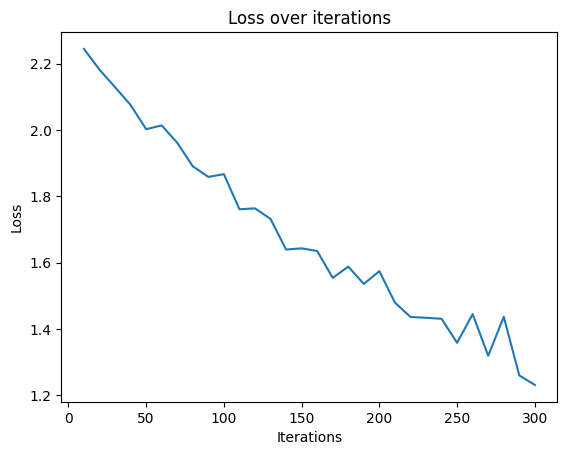

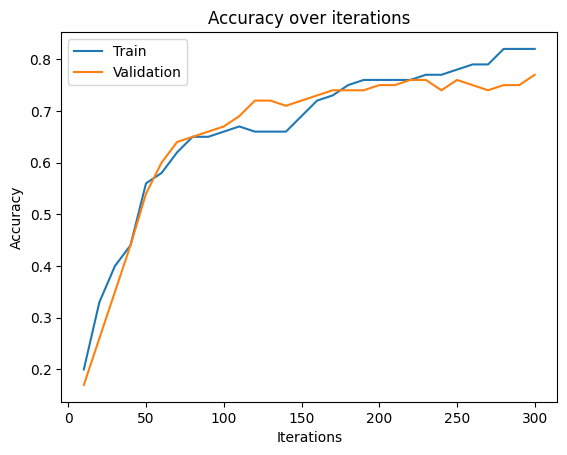

In [106]:
def train_model(model,
                train_data,
                val_data,
                learning_rate=0.005,
                batch_size=100,
                num_epochs=10,
                plot_every=10):
    """
    Train the PyTorch model `model` using the training data `train_data` and the
    corresponding hyperparameters. Report training loss, training accuracy, and
    validation accuracy every `plot_every` iterations.
    """
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                z = model(images.reshape(-1, 784)) # TODO

                loss = criterion(z, labels) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    train_loss.append(float(loss))
                    train_acc.append(accuracy(model, train_data))
                    val_acc.append(accuracy(model, val_data))
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

model = nn.Linear(784, 10)
train_model(model, train_data, val_data)

## Part 5. Hyperparameter Tuning

Our training process is not yet complete.
In general, the performance of machine learning models depend heavily on
the hyperparameter settings used.
Hyperparameters are settings that cannot be tuned via gradient descent in a straightforward way.
These settings can affect the model architecture, but may also affect the optimization process.

**Graded Task**: What are some examples of hyperparameters that affect the model architecture of a model?
You may consider some hyperparameters that you learned about in CSC311. List at least 3 examples.

In [ ]:
# TODO: Number of layers, number of neurons in each layer, the kernel size.

**Task**: What are some examples of hyperparameters that affect the optimization process?

In [ ]:
# TODO: The learning rate, and the batch size

Model architecture related hyperparameters are important to tune and should *not* be neglected in
practical application.  However, since we are working with a linear model right now, we are limited
in this lab to exploring the optimization hyperparameters.

**Task**: What happens if the learning rate is too small?
Provide an example training curve by calling `train_model` with a low learning rate,
and describe the features of the training curve that you see.

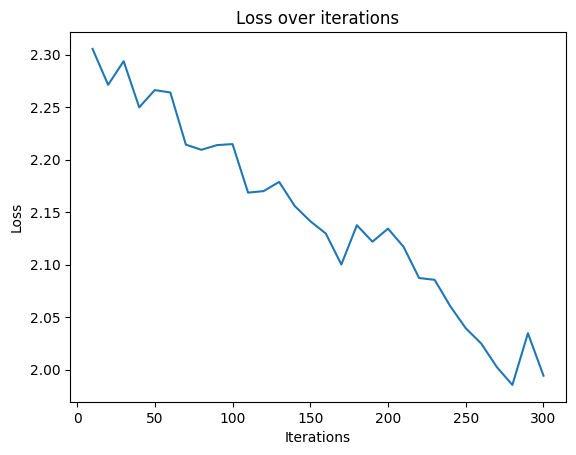

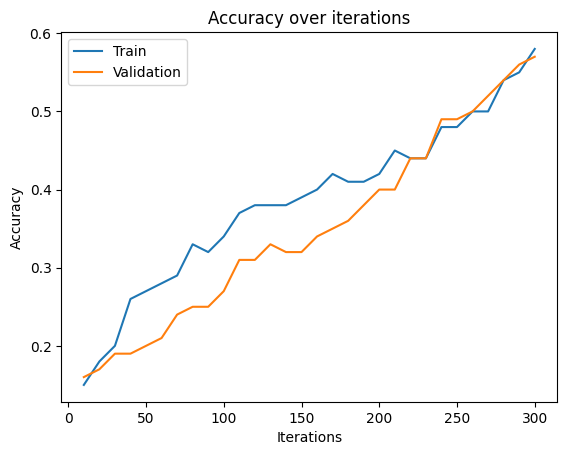

In [107]:
# What happens is that it takes much longer for it to converge. the accuracy tanks (falls down) with a much smaller
# learning rate.
model = nn.Linear(784, 10)
train_model(model, train_data, val_data, learning_rate = 0.001)

**Graded Task**: What happens if the learning rate is too large?
Provide an example training curve by calling `train_model` with a large learning rate,
and describe the features of the training curve that you see.

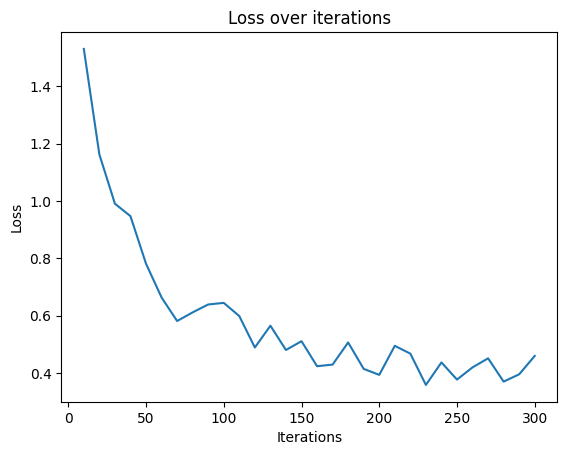

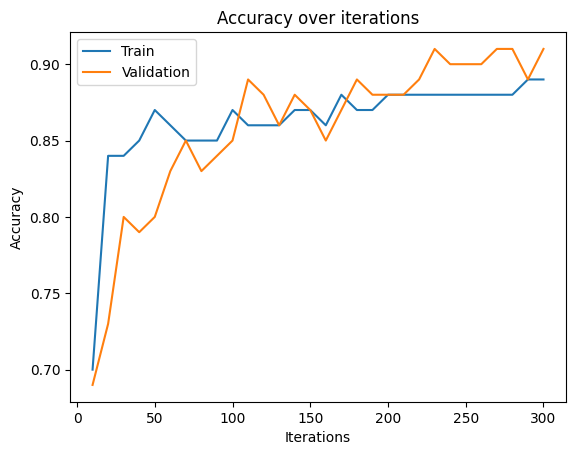

In [111]:
# It looks like the loss decreases significantly. The loss is much lower, the accuracy is much larger. The accuracy starts off
# higher much quicker as well.
model = nn.Linear(784, 10)
train_model(model, train_data, val_data, learning_rate = 0.1)

Hyperparameter choices interact with one another.
Thus, practitioners use a strategy called **grid search** to try
all variations of hyperparameters from a set of hyperparameters.
We will not do that here since linear models don't yet have many hyperparameters
to work with.

**Task**: Choose the best model that you have trained. Typically we make this choice
using the validation accuracy. To understand how well the model you choose would
generalize to unseen data, we use the *test data*.
Compute the test accuracy for this model by calling the function `accuracy()`
on the model and the test data.

tensor(0.8700)

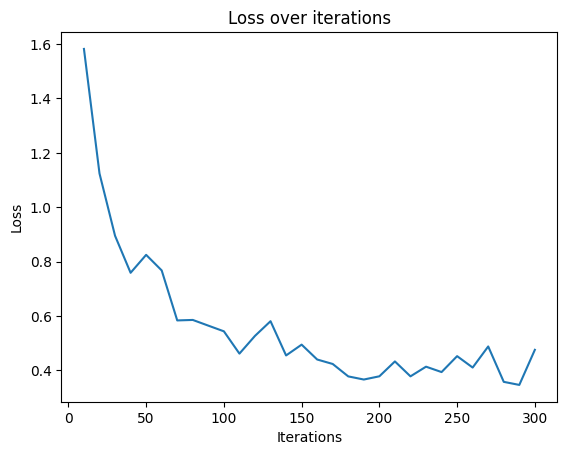

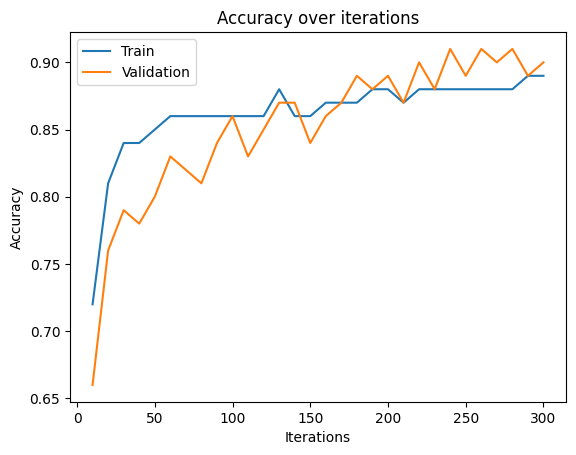

In [112]:
# TODO: Compute the test accuracy
model = nn.Linear(784, 10)
train_model(model, train_data, val_data, learning_rate = 0.1)
accuracy(model, test_data)